In [1]:
import cv2
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Model
from keras.utils import np_utils
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
epochs = 10
batch_size = 50
row_col = 48

In [3]:
# 原始的 MNIST 是 6000 筆 28*28 灰階
def load_data():
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    X_train, y_train = X_train[:5000], y_train[:5000]
    X_test, y_test = X_test[5000:6000], y_test[5000:6000]
    X_train = [cv2.cvtColor(cv2.resize(i, (row_col, row_col)), cv2.COLOR_GRAY2RGB)
            for i in X_train]
    X_train = np.concatenate([arr[np.newaxis] for arr in X_train]).astype('float32')
    X_test = [cv2.cvtColor(cv2.resize(i, (row_col, row_col)), cv2.COLOR_GRAY2RGB)
            for i in X_test]
    X_test = np.concatenate([arr[np.newaxis] for arr in X_test]).astype('float32')

    X_train = X_train / 255
    X_test = X_test / 255

    y_train_ohe = np_utils.to_categorical(y_train, 10)
    y_test_ohe = np_utils.to_categorical(y_test, 10)

    return (X_train, y_train_ohe), (X_test, y_test_ohe)
 
def load_model():
    base_network = VGG16(include_top=False, weights='imagenet', input_shape=(row_col, row_col, 3))
 
    # 凍結預設的參數
    for layer in base_network.layers:
        layer.trainable = False
 
    # 接上自行定義的全連結層
    model = Flatten()(base_network.output)
    model = Dense(4096, activation='relu', name='full_connect_1')(model)
    model = Dense(4096, activation='relu', name='full_connect_2')(model)
    model = Dropout(0.5)(model)
    model = Dense(10, activation='softmax', name='prediction')(model)
    model = Model(base_network.input, model, name='my_model')

    return model

In [4]:
# 載入模型
model = load_model()
model.summary()
 
# 載入訓練資料
(x_train, y_train_ohe), (x_test, y_test_ohe) = load_data()
print('Train Size:', x_train.shape)
print('Test Size:', x_test.shape)
 
#定義 loss function
from keras.optimizers import SGD
sgd = SGD(lr=0.05, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
 
# 開始訓練
model.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=epochs, batch_size=batch_size)
 
# 輸出結果
print('Train Acc:', model.evaluate(x_train, y_train_ohe)[1])
print('Test Acc:', model.evaluate(x_test, y_test_ohe)[1])

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 79s 1us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_____________________

In [5]:
np.where(y_test_ohe[1]==1)

(array([9], dtype=int64),)

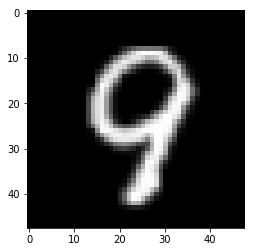

In [7]:
from matplotlib.pyplot import imshow
imshow(x_test[1])